In [2]:
import rasterio 
import rioxarray as rio
import xarray
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import geopandas as gpd
from shapely.geometry import box, Point, Polygon
import glob
import geopandas as gpd
#from geodatasets import get_path
import pdb
import array as arr


In [3]:
def find_crs(east_image,north_image,data,east_crs,north_crs,buffer):
    """
        Find the east, north and maximum value of each corner reflector in the SWESARR's data

    Parameters: east_image: 1D numpy.ndarray in the size of (data['x']), east coordinate of the image
                north_image: 1D numpy.ndarray in the size of (data['y']), north coordinate of the image
                data: swesarr data
                east_crs: float, east coordinate of a corner reflector
                north_crs: float, north coordinate of a corner reflector
    """
    # find the east and north buffer zone
    ind_east = np.where((east_image > east_crs - buffer) & (east_image < east_crs + buffer))[0]
    ind_north = np.where((north_image > north_crs - buffer) & (north_image < north_crs + buffer))[0]
    # data[ind_north][:,ind_east]: data in the buffer zone
    # np.argmax can return the index of the maximum values of the input. However, the output is flatten from 2d to 1d.
    # np.unravel_index is used to recover the dimension from the np.argmax because we are interested in the index of north and east.
    # (ind_north.shape[0],ind_east.shape[0]) is the orginal data dimension.
    ind_max_north,ind_max_east = np.unravel_index(np.argmax(data[ind_north][:,ind_east]),(ind_north.shape[0],ind_east.shape[0]))
    #pdb.set_trace()
    return east_image[ind_east[ind_max_east]], north_image[ind_north[ind_max_north]], data[ind_north[ind_max_north],ind_east[ind_max_east]]
    

In [4]:
def cr_plot(cr_data,figsize=(16,4),xlabel='',ylabel='',title=''):
    fig = plt.figure()
    plt.figure(figsize=figsize)
    plt.plot(cr_data,marker = '*')
    plt.grid()
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    plt.title(title)

In [5]:
def cr_boxplot(cr_data,figsize=(12,4),labels='',xlabel='',ylabel='',title=''):
    fig = plt.figure()
    plt.figure(figsize=figsize)
    plt.boxplot(cr_data.dropna().values)
    # cr_data.boxplot() #keeping the nan's
    plt.xticks(range(1,cr_data.shape[1] + 1),labels)
    plt.grid()
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel)
    plt.title(title)

In [6]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        dict1['IQR'] = bp['boxes'][i].get_ydata()[2] - bp['boxes'][i].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

In [7]:
# read swesarr data
swesarr_file_path = "/home/jovyan/shared-public/swesarr project!/swesarr-radar/v3_tifs/"
tif_list = glob.glob(os.path.join(swesarr_file_path,'*.tif'))
SWESARR = rio.open_rasterio("/home/jovyan/shared-public/swesarr project!/swesarr-radar/GRMST1_27702_20007_009_200211_225_XX_01/GRMST1_27702_20007_009_200211_09225VV_XX_01.tif")
swesarr_data = SWESARR[0]

In [8]:
# read CRs data
cr_fp = "corner_reflectors/XYSWESARR_reflectors_oct2019.shp" # set filepath
# read file using gpd.read_file()
CRs_data = gpd.read_file(cr_fp)
east_crs = CRs_data['Easting']
north_crs = CRs_data['Northing']
del CRs_data

In [9]:
# find the location and maximum values
crs_all = np.zeros((len(tif_list),east_crs.shape[0],6))
crs_all[:,:,:2] = np.vstack((east_crs,north_crs)).T
buffer = 20 # bigger 20

for i in range(len(tif_list)):
    SWESARR = rio.open_rasterio(tif_list[i])
    gdf = gpd.read_file("/home/jovyan/shared-public/swesarr_project/swesarr-roi/swesarr-roi.shp")
    gdf_transform = gdf.to_crs(epsg=26912)
    
    ###Mask SWESARR
    geometries = gdf_transform.geometry.tolist()
    SWESARR_clipped = SWESARR.rio.clip(geometries, drop=True)
    SWESARR_transform = SWESARR_clipped.rio.transform()
    
    # Convert the DataArray to a numpy array for rasterio.plot.show
    SWESARR_np = SWESARR_clipped[0].values  # Convert the first band to a numpy array
    SWESARR_np[SWESARR_np == 0 ] = np.nan
    for j in range(east_crs.shape[0]):
        crs_all[i,j,2:5] = find_crs(SWESARR_clipped['x'].values,SWESARR_clipped['y'].values,SWESARR_np,east_crs[j],north_crs[j],buffer)
    
    del SWESARR, SWESARR_clipped
    distance = np.sqrt((crs_all[i,:,0] - crs_all[i,:,2])**2 + (crs_all[i,:,1] - crs_all[i,:,3])**2)
    crs_all[i,:,5] = distance


In [10]:
# get the maximum values with each flight
crs_max = np.zeros((east_crs.shape[0],len(tif_list)))
for i in range(len(tif_list)):
    for j in range(east_crs.shape[0]):
        crs_max[j,i] = crs_all[i][j,4]
crs_max.shape

(7, 14)

In [11]:
cr = {'191104-1': crs_max[:,6],
    '191104-2': crs_max[:,12],
    '191105-1': crs_max[:,8],
    '191105-2': crs_max[:,10],
    '191105-3': crs_max[:,3],
    '191106-1': crs_max[:,4],
    '191106-2': crs_max[:,0],
    '191106-3': crs_max[:,1],
    '200211-1': crs_max[:,7],
    '200211-2': crs_max[:,5],
    '200211-3': crs_max[:,2],
    '200212-1': crs_max[:,11],
    '200212-2': crs_max[:,13],
    '200212-3': crs_max[:,9]}
df = pd.DataFrame(cr)
df.index = ['CR1','CR2','CR3','CR4','CR5','CR6','CR7']
cr_data = np.transpose(df)
cr_data

,CR1,CR2,CR3,CR4,CR5,CR6,CR7
191104-1,31.828583,30.519093,32.872116,30.229469,NaN,30.461197,1.622823
191104-2,29.982620,27.934847,31.002209,27.892561,NaN,27.566381,-7.018228
191105-1,30.755709,28.995764,30.374420,27.914543,27.547480,30.326185,-3.679844
191105-2,32.515373,30.234838,30.680155,29.009754,24.663914,28.987204,-4.231534
191105-3,30.208082,29.216299,29.560284,30.391924,27.003227,30.501562,-3.942795
191106-1,31.864843,29.831190,31.346231,27.797321,23.459415,28.891855,-4.235094
191106-2,30.305223,30.404232,31.021688,27.581749,25.489754,27.282013,-5.744321
191106-3,28.802898,28.371561,29.838068,28.142971,27.745483,29.203070,-4.894459
200211-1,29.149179,27.983299,28.443510,NaN,NaN,NaN,NaN
200211-2,29.557951,27.031391,28.926178,25.934223,24.896502,29.657393,2.311856


Text(0.5, 1.0, 'Corner Reflector Locations')

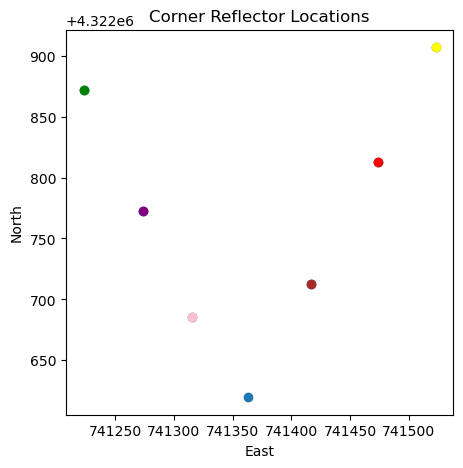

In [12]:
# plot CRs locations
plt.figure(figsize=(5,5))
plt.scatter(east_crs, north_crs)
plt.scatter(east_crs[1], north_crs[1], color='pink')#CR2
plt.scatter(east_crs[2], north_crs[2], color='brown')#CR3
plt.scatter(east_crs[3], north_crs[3], color='red')#CR4
plt.scatter(east_crs[4], north_crs[4], color='yellow')#CR5 
plt.scatter(east_crs[5], north_crs[5], color='green')#CR6 
plt.scatter(east_crs[6], north_crs[6], color='purple')#CR7 
plt.xlabel('East')
plt.ylabel('North')
plt.title("Corner Reflector Locations")


/tmp/ipykernel_158/687499165.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(cr_data16.dropna().values, labels=labels)


,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker,IQR
0,CR1,27.942327,29.238113,30.175855,30.643087,32.515373,1.404974
1,CR2,27.031391,28.459205,29.106031,30.019577,30.404232,1.560372
2,CR3,28.926178,29.629730,30.527287,31.152576,31.694252,1.522846
3,CR4,27.581749,27.826627,28.393737,28.932051,30.391924,1.105424
4,CR5,23.459415,24.722061,26.246490,27.695982,28.660944,2.973922
5,CR6,27.282013,28.915692,29.304667,30.158987,30.625135,1.243295


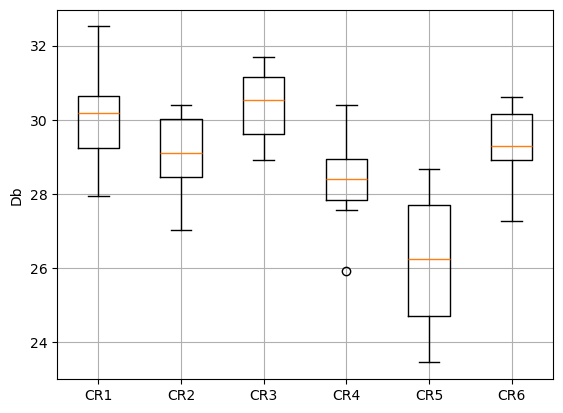

In [13]:
labels = ['CR1','CR2','CR3','CR4','CR5','CR6']
cr_data16 = cr_data[['CR1','CR2','CR3','CR4','CR5','CR6']]
bp = plt.boxplot(cr_data16.dropna().values, labels=labels)
plt.grid()
plt.ylabel('Db')
get_box_plot_data(labels, bp)
#plt.show()

<Figure size 640x480 with 0 Axes>

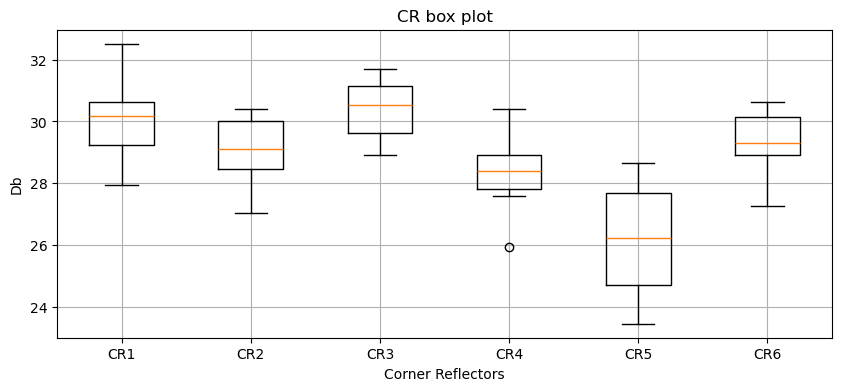

In [14]:
labels16 = ['CR1','CR2','CR3','CR4','CR5','CR6']
my_path = '/home/jovyan/repos/swesarr_original/contributors/melody/'
cr_data16 = cr_data[['CR1','CR2','CR3','CR4','CR5','CR6']]
cr_boxplot(cr_data16,figsize=(10,4),labels=labels16,xlabel='Corner Reflectors',ylabel='Db',title='CR box plot')
script_dir = os.path.dirname(my_path)
results_dir = os.path.join(script_dir, 'Results/')
sample_file_name = 'CRs box plot'
plt.savefig(results_dir + sample_file_name)

<Figure size 640x480 with 0 Axes>

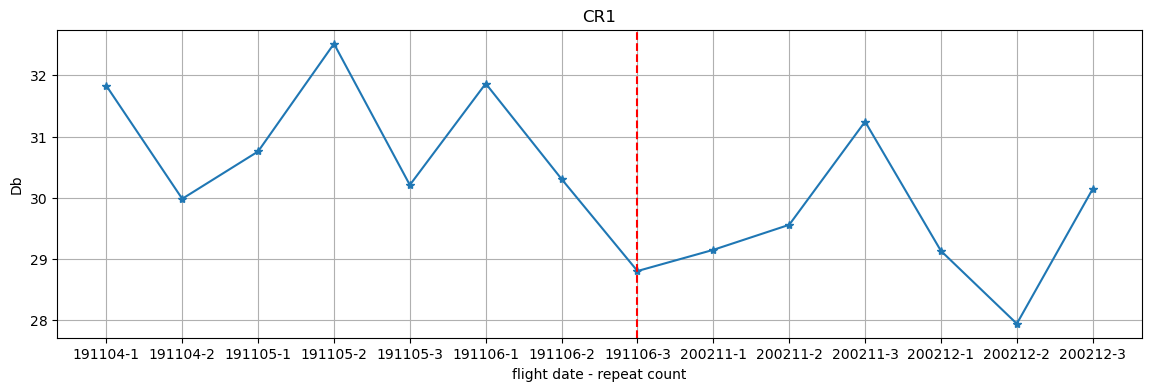

<Figure size 640x480 with 0 Axes>

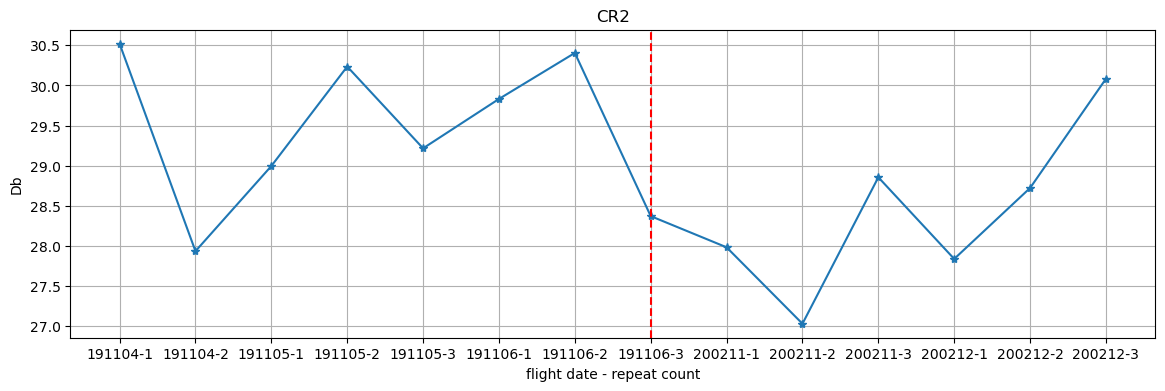

<Figure size 640x480 with 0 Axes>

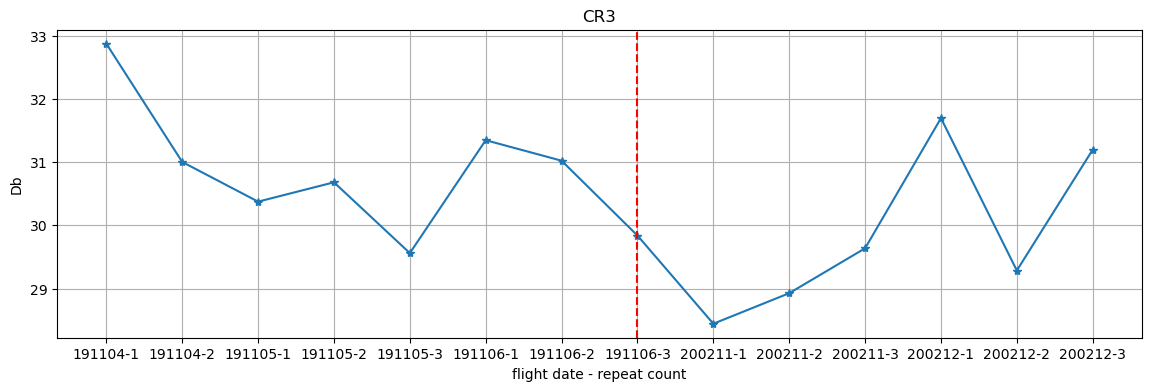

<Figure size 640x480 with 0 Axes>

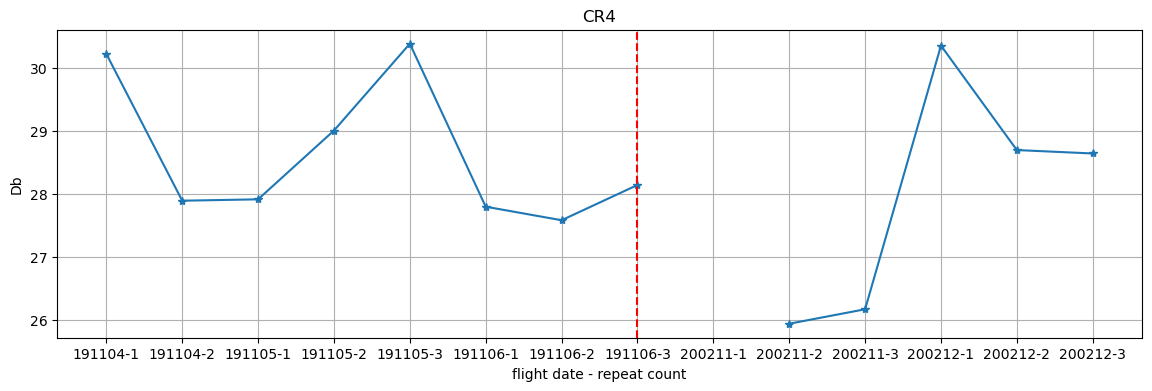

<Figure size 640x480 with 0 Axes>

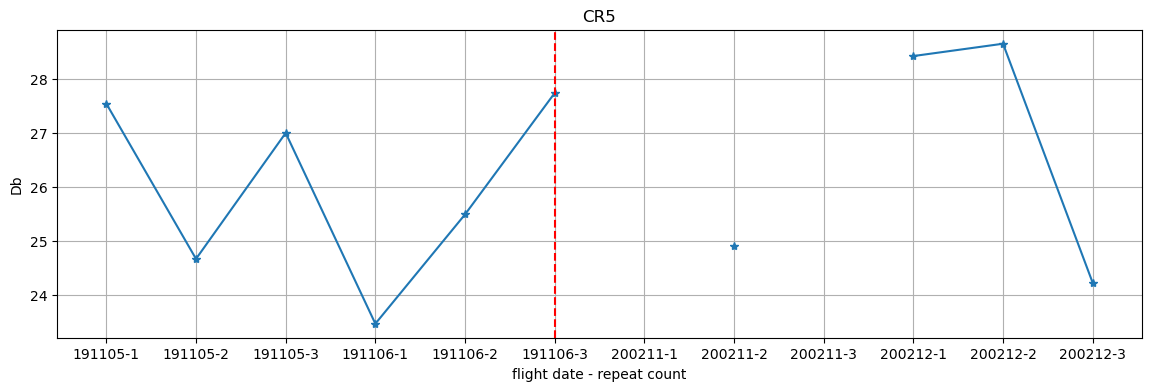

<Figure size 640x480 with 0 Axes>

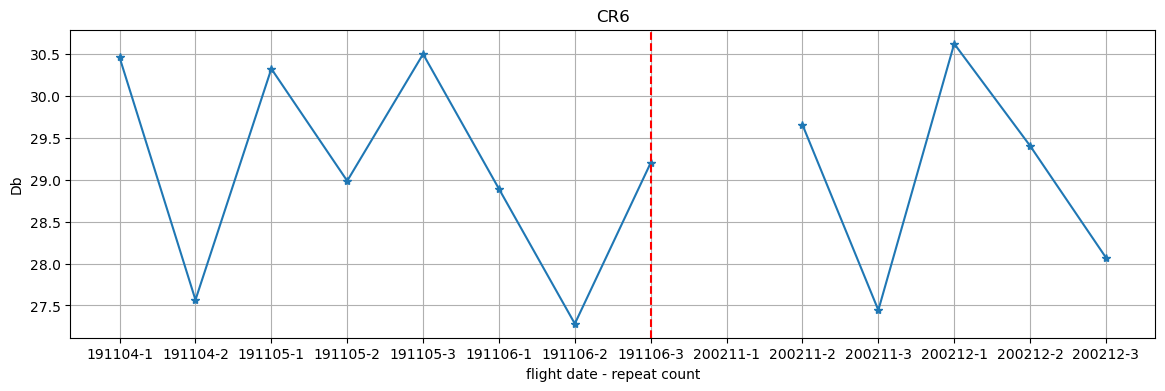

In [15]:
title = ['CR1','CR2','CR3','CR4','CR5','CR6']
for i in range(len(title)):
    cr_plot(cr_data16[title[i]],figsize=(14,4),xlabel='flight date - repeat count',ylabel='Db',title=title[i])
    plt.axvline(x = 7, color = 'r',linestyle='dashed')
    script_dir = os.path.dirname(my_path)
    results_dir = os.path.join(script_dir, 'Results/')
    sample_file_name = title
    plt.savefig(results_dir + sample_file_name[i])
    
    #plt.close()

In [16]:
# plot the location and maximum values
i = 12
d = {'Easting_CR': crs_all[i][:,0],
        'Northing_CR': crs_all[i][:,1],
        'Easting_max': crs_all[i][:,2],
        'Northing_max': crs_all[i][:,3],
        'Maximum value': crs_all[i][:,4],
        'Distance': crs_all[i][:,5]}
df = pd.DataFrame(d)
#df

In [17]:
# plot CRs locations
plt.figure(figsize=(5,5))
plt.scatter(east_crs, north_crs)
plt.scatter(east_crs[4], north_crs[4], color='red')
plt.xlabel('East')
plt.ylabel('North')
plt.title("Corner Reflector Locations")
plt.close()

In [8]:
'''
with pd.ExcelWriter('test.xlsx',engine='xlsxwriter') as writer:
    for i in range(crs_all.shape[0]):
        d = {'Easting_CR': crs_all[i][:,0],
        'Northing_CR': crs_all[i][:,1],
        'Easting_max': crs_all[i][:,2],
        'Northing_max': crs_all[i][:,3],
        'Maximum value': crs_all[i][:,4],
        'Distance': crs_all[i][:,5]}
        df = pd.DataFrame(d)
        df.to_excel(writer,sheet_name=f"image {i}")
print(df)
'''


'\nwith pd.ExcelWriter(\'test.xlsx\',engine=\'xlsxwriter\') as writer:\n    for i in range(crs_all.shape[0]):\n        d = {\'Easting_CR\': crs_all[i][:,0],\n        \'Northing_CR\': crs_all[i][:,1],\n        \'Easting_max\': crs_all[i][:,2],\n        \'Northing_max\': crs_all[i][:,3],\n        \'Maximum value\': crs_all[i][:,4],\n        \'Distance\': crs_all[i][:,5]}\n        df = pd.DataFrame(d)\n        df.to_excel(writer,sheet_name=f"image {i}")\nprint(df)\n'

In [ ]:
plt.plot(np.arange(swesarr_data.data[~np.isnan(swesarr_data.data)].shape[0]),np.sort(swesarr_data.data[~np.isnan(swesarr_data.data)]))
plt.xlable('number of data')
plt.ylable('Db')

In [30]:
labels7 = ['CR7']
cr_data7 = cr_data[['CR7']]
cr_boxplot(cr_data7,figsize=(10,4),labels=labels7,xlabel='',ylabel='Db',title='CR7 box plot')
script_dir = os.path.dirname(my_path)
results_dir = os.path.join(script_dir, 'Results/')
sample_file_name = 'CR7 box plot'
plt.savefig(results_dir + sample_file_name)
plt.close()

<Figure size 640x480 with 0 Axes>